<a href="https://colab.research.google.com/github/claredavies/AutomaticLearning/blob/main/Assignment1/SupervisedLearningAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [3]:
import numpy as np
from google.colab import files
import pandas as pd
from matplotlib import pyplot as plt
from pandas.api.types import is_numeric_dtype
from pandas.api.types import is_string_dtype
import re
import socket
from scipy.stats import zscore
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from matplotlib import pyplot

In [4]:
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.set_option('display.max_rows', None)

# Read in Files

In [5]:
!git clone https://github.com/claredavies/AutomaticLearning

Cloning into 'AutomaticLearning'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 70 (delta 19), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (70/70), done.


In [6]:
%ls

AutomaticLearning/  sample_data/


In [7]:
%cd AutomaticLearning/Assignment1/Data/

/content/AutomaticLearning/Assignment1/Data


In [8]:
df = pd.read_csv('ds_03.csv')
df.head(3)

,V01,V02,V03,V04,V05,V06,V07,V08,V09,V10,...,V29,V30,V31,V32,V33,V34,V35,V36,class,target
0,8.82,3.50,10.88,41.70,10.17,NaN,4.18,16.42,3.75,12.87,...,29.30,16.2,10.21,3.84,38.06,NaN,8.47,7.68,1,0.3911
1,12.49,5.08,13.39,35.88,7.02,11.0,6.92,15.35,4.99,6.88,...,68.45,NaN,16.62,4.61,NaN,33.78,9.05,6.12,4,0.4179
2,14.07,3.99,10.87,27.80,9.82,10.6,4.10,NaN,3.34,11.65,...,50.44,NaN,16.84,3.16,39.22,29.64,10.30,11.22,4,0.4090


# Functions

In [9]:
def return_columns_missing_values(df):
  return df.columns[df.isnull().any()]

In [10]:
def missing_value_column_percentage(dataframe, column_name):
  percent_missing = dataframe.loc[:, column_name].isnull().sum() * 100 / len(dataframe)
  return percent_missing

In [11]:
def checkNumberMissingValuesInRowAboveThreshold(dataframe, threshold):
  listMissingValuesAboveThresh = []
  for i in range(len(dataframe.index)):
    resultMissing = dataframe.iloc[i].isnull().sum()
    index = dataframe.iloc[i].index
    if resultMissing > threshold:
      listMissingValuesAboveThresh.append(i)
  # print(listMissingValuesAboveThresh)
  df = dataframe.drop(listMissingValuesAboveThresh, inplace=False)
  return df

In [12]:
def checkZScoreHigherThreshold(dataframe, threshold):
  listOverThreshold = []
  dfZValues = dataframe.apply(stats.zscore)
  for col in dataframe.columns:
    if col != "class":
      found = dfZValues.index[dfZValues[col]>threshold].tolist()
      listOverThreshold = listOverThreshold + found
  listOverThreshold = list(dict.fromkeys(listOverThreshold))
  # print(listOverThreshold)
  df = dataframe.drop(listOverThreshold, inplace=False)
  return df

# T1.a

ai. samples with more than 4 missing feature values have to be dropped,

In [13]:
dfClean = checkNumberMissingValuesInRowAboveThreshold(df, 4)

aii. the remaining missing values have to be filled using the average value, and

In [14]:
dfClean = dfClean.fillna(dfClean.mean())

aiii. samples with at least one feature value with a z-score higher than 3 (i.e. an outlier) have to be discarded.

In [15]:
dfClean = checkZScoreHigherThreshold(dfClean, 3)

# T1.b

It is suspected that not all 36 features are needed for a successful classification. To remove unnecessary
dimensions and reduce the computation time, it is decided to keep only those features that account for
up to 95% of the variance of the data.

In [16]:
X = dfClean.drop("class", axis=1)
Y = dfClean['class']

In [19]:
def findWantedKforPCA(dataframe, threshold):
  for i in range(len(dataframe.columns)):
    pca = PCA(n_components=i)
    principalComponents1 = pca.fit_transform(dataframe)
    variance = sum(pca.explained_variance_ratio_)
    if variance > threshold:
      return i
  print("unable to met threshold")
  return 0

In [20]:
n = findWantedKforPCA(X, 0.95)
print("number of features needed for 95% variance:  " + str(n))
pca = PCA(n_components=n)
principalComponents = pca.fit_transform(X)

pca.explained_variance_ratio_
print(sum(pca.explained_variance_ratio_))

number of features needed for 95% variance:  14
0.9500589973831068


In [21]:
Xpca = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3', 'principal component 4','principal component 5','principal component 6','principal component 7','principal component 8','principal component 9','principal component 10',
                          'principal component 11','principal component 12','principal component 13', 'principal component 14'])

Xpca.tail()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,principal component 11,principal component 12,principal component 13,principal component 14
918,10.517648,8.849201,-10.580086,16.411439,7.663826,-15.744594,8.478718,-9.244069,-0.783213,-0.249702,2.251763,-4.002762,5.771818,1.415477
919,3.628870,0.804786,-12.244010,2.127585,14.357679,-1.606728,8.616712,13.178789,-1.285939,-1.847375,7.393570,-1.256483,0.891204,-2.310301
920,-38.292032,35.411712,-1.974346,-8.600256,-1.253000,-4.488746,-7.452547,7.342709,4.758288,-9.356935,1.554262,3.106589,-2.925256,-0.098442
921,41.345595,-17.492213,-5.649815,2.941931,-2.678740,3.914277,-11.742452,0.371266,-16.114407,-13.910340,-3.600465,-1.382746,-4.090212,0.301882
922,-19.948580,13.821654,-0.024228,-13.221582,0.761577,8.282948,2.931496,-9.340231,16.107986,5.192688,-2.260428,4.466093,0.201771,0.346512


# T1.c

Normalize the data using mu-sigma standardization.

In [22]:
standardizer = StandardScaler()
X = standardizer.fit_transform(Xpca)

In [23]:
X = pd.DataFrame(data = X
             , columns = ['principal component 1', 'principal component 2','principal component 3', 'principal component 4','principal component 5','principal component 6','principal component 7','principal component 8','principal component 9','principal component 10',
                          'principal component 11','principal component 12','principal component 13', 'principal component 14'])

In [24]:
print(X.head())

   principal component 1  principal component 2  principal component 3  \
0               0.313434               0.841294              -0.472641   
1              -0.315836              -0.262807               1.914726   
2              -0.158084              -0.351200               0.467123   
3               0.569296              -0.257306               0.758210   
4              -0.866370               0.140033               0.502157   

   principal component 4  principal component 5  principal component 6  \
0              -0.230768               0.447245              -0.688859   
1               0.610557               0.281744              -0.229400   
2              -0.422589              -0.566503              -0.164481   
3               0.328537               1.860091               0.567699   
4               0.998485              -1.935781              -1.256409   

   principal component 7  principal component 8  principal component 9  \
0              -0.942207            

# T1.d

Finally, calculate the imbalance ratio (IR) of the dataset

In [25]:
result = Y.value_counts()

In [26]:
print(result)

4    240
1    215
0    161
5    152
3     80
2     75
Name: class, dtype: int64


In [27]:
IR = max(result)/min(result)
print("Imbalance ratio:  " + str(IR))

Imbalance ratio:  3.2


# T2.a

It is believed that maybe a single classifier is not going to be able to solve the problem satisfactorily and hence
it is decided to consider several models:
1) Gaussian Naive Bayes (GNB)
2) Logistic Regression (LR)
3) Decision Tree (DT)
4) Support Vector Machine (SVM)

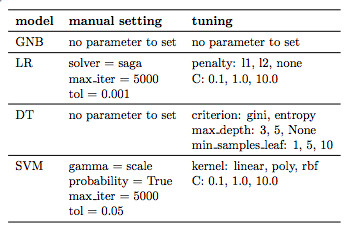

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.2, random_state =0)

LR Grid Search - penalty l1 not explored as not supported by manual setting of solver=*saga*

In [29]:
logistic = linear_model.LogisticRegression()
C = [0.1, 1.0, 10.0]
penalty = ["none", "l2"]
hyperparameters = dict(C=C, penalty=penalty)

In [30]:
clf = GridSearchCV(logistic, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(X, Y)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the

In [31]:
print("Best Penalty:", best_model.best_estimator_.get_params()["penalty"])
print("Best C:", best_model.best_estimator_.get_params()["C"])

Best Penalty: l2
Best C: 1.0


DT - Grid Search

In [32]:
dt = DecisionTreeClassifier()
criterion = ["gini", "entropy"]
max_depth = [3, 5, None]
min_samples_leaf = [1, 5, 10]
hyperparameters = dict(criterion=criterion, max_depth=max_depth, 
                       min_samples_leaf=min_samples_leaf)

In [33]:
clf = GridSearchCV(dt, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(X, Y)

In [34]:
print("Best criterion:", best_model.best_estimator_.get_params()["criterion"])
print("Best max_depth:", best_model.best_estimator_.get_params()["max_depth"])
print("Best min_samples_leaf:", best_model.best_estimator_.get_params()["min_samples_leaf"])

Best criterion: entropy
Best max_depth: None
Best min_samples_leaf: 1


SVM - Grid Search

In [35]:
svm = SVC()
kernel = ["linear", "poly", "rbf"]
C = [0.1, 1.0, 10.0]
hyperparameters = dict(kernel = kernel, C = C)

In [36]:
clf = GridSearchCV(svm, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(X, Y)

In [37]:
print("Best C:", best_model.best_estimator_.get_params()["C"])
print("Best kernel:", best_model.best_estimator_.get_params()["kernel"])

Best C: 1.0
Best kernel: rbf


# T2.b

In [38]:
models = {}

models['GNB'] = GaussianNB()
models['LR'] = LogisticRegression(C = 1, penalty = 'l2', solver ='saga', max_iter = 5000, tol = 0.001)
models['DT'] = DecisionTreeClassifier(criterion= "entropy", max_depth = None,  min_samples_leaf= 1)
models['SVM'] = SVC(C= 1.0, kernel= "rbf", gamma = "scale", probability = True, max_iter = 5000, tol = 0.05)

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from numpy import mean
from numpy import std
from sklearn.metrics import SCORERS
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

accuracy, precision, recall, f1Score, predictions = {}, {}, {}, {}, {}

for key in models.keys():
    # print(SCORERS.keys())
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=2652124)
    accuracyFound = cross_val_score(models[key], X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    precisionFound = cross_val_score(models[key], X_train, y_train, scoring='precision_micro', cv=cv, n_jobs=-1)
    recallFound = cross_val_score(models[key], X_train, y_train, scoring='recall_micro', cv=cv, n_jobs=-1)
    f1Found = cross_val_score(models[key], X_train, y_train, scoring='f1_micro', cv=cv, n_jobs=-1)

    #performance result
    print('Accuracy: %.3f (%.3f)' % (mean(accuracyFound), std(accuracyFound)))
    print('Precision: %.3f (%.3f)' % (mean(precisionFound), std(precisionFound)))
    print('Recall: %.3f (%.3f)' % (mean(recallFound), std(recallFound)))
    print('f1: %.3f (%.3f)' % (mean(f1Found), std(f1Found)))
 
    accuracy[key] = mean(accuracyFound)
    precision[key] = mean(precisionFound)
    recall[key] = mean(recallFound)
    f1Score[key] = mean(f1Found)

Accuracy: 0.634 (0.028)
Precision: 0.634 (0.028)
Recall: 0.634 (0.028)
f1: 0.634 (0.028)
Accuracy: 0.643 (0.038)
Precision: 0.643 (0.038)
Recall: 0.643 (0.038)
f1: 0.643 (0.038)
Accuracy: 0.508 (0.044)
Precision: 0.514 (0.038)
Recall: 0.516 (0.041)
f1: 0.502 (0.035)
Accuracy: 0.767 (0.032)
Precision: 0.767 (0.032)
Recall: 0.767 (0.032)
f1: 0.767 (0.032)


# T2.C

     Accuracy  Precision    Recall        F1
GNB  0.634170   0.634170  0.634170  0.634170
LR   0.643170   0.643170  0.643170  0.643170
DT   0.508172   0.514022  0.515827  0.501832
SVM  0.766936   0.766936  0.766936  0.766936


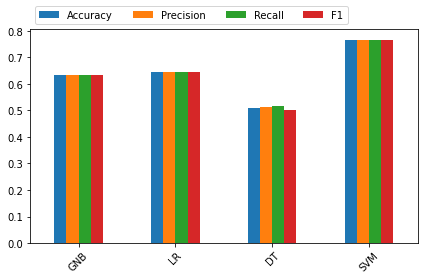

In [40]:
df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()
df_model['F1'] = f1Score.values()

print(df_model)

ax  = df_model.plot.bar(rot=45)
ax.legend(ncol= len(models.keys()), bbox_to_anchor=(0, 1), loc='lower left', prop={'size': 10})
plt.tight_layout()

# T3.A

In [61]:
# get a voting ensemble of models
def get_voting(hardOrSoft):
 # define the base models
 # define the voting ensemble
  models = list()

  models.append(('GNB', GaussianNB()))
  models.append(('LR', LogisticRegression(C = 1, penalty = 'l2', solver ='saga', max_iter = 5000, tol = 0.001)))
  models.append(('DT', DecisionTreeClassifier(criterion= "entropy", max_depth = None,  min_samples_leaf= 1)))
  models.append(('SVM', SVC(C= 1.0, kernel= "rbf", gamma = "scale", probability = True, max_iter = 5000, tol = 0.05)))

  # define the voting ensemble
  ensemble = VotingClassifier(estimators=models, voting=hardOrSoft)
  return ensemble

In [65]:
def get_models(hardOrSoft):
  models = dict()

  models['GNB'] = GaussianNB()
  models['LR'] = LogisticRegression(C = 1, penalty = 'l2', solver ='saga', max_iter = 5000, tol = 0.001)
  models['DT'] = DecisionTreeClassifier(criterion= "entropy", max_depth = None,  min_samples_leaf= 1)
  models['SVM'] = SVC(C= 1.0, kernel= "rbf", gamma = "scale", probability = True, max_iter = 5000, tol = 0.05)

  models[hardOrSoft] = get_voting(hardOrSoft)
  return models

In [63]:
def evaluate_model(model, X, y):
 cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
 scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
 return scores

name:  GNB
>GNB 0.640 (0.051)
name:  LR
>LR 0.653 (0.046)
name:  DT
>DT 0.517 (0.044)
name:  SVM
>SVM 0.784 (0.037)
name:  hard
>hard 0.710 (0.044)


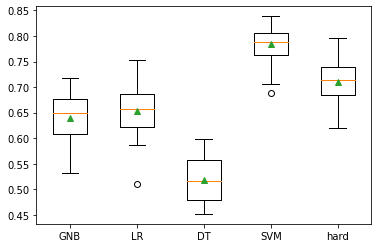

In [66]:
models = get_models('hard')
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
 print("name:  " + name)
 scores = evaluate_model(model, X, Y)
 results.append(scores)
 names.append(name)
 print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

name:  GNB
>GNB 0.640 (0.051)
name:  LR
>LR 0.653 (0.046)
name:  DT
>DT 0.515 (0.043)
name:  SVM
>SVM 0.784 (0.037)
name:  soft
>soft 0.694 (0.038)


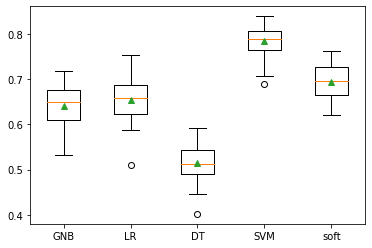

In [67]:
models = get_models('soft')
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
 print("name:  " + name)
 scores = evaluate_model(model, X, Y)
 results.append(scores)
 names.append(name)
 print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [ ]:
ensemble = get_voting("hard")
ensemble.fit(X, Y)